## Stuff needed to get things going
### TODO This should reduce to a few lines of common imports

In [1]:
from os import environ, remove
from configparser import ConfigParser
from glob import glob
from os.path import abspath

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs
from cftime import num2date

import hydrostats.metrics as hm

import pickle

from grpc4bmi.bmi_client_docker import BmiClientDocker
from ewatercycle.observation.grdc import get_grdc_data

### TODO functions needed to port data from one format / library to another. This should become part of the imports above

In [2]:
def var_to_xarray(model, variable):
    # Get grid properties from model (x = latitude !!)
    # could be speedup, lots of bmi calls are done here that dont change between updates
    shape = model.get_grid_shape(model.get_var_grid(variable))
    lat = model.get_grid_x(model.get_var_grid(variable))
    lon = model.get_grid_y(model.get_var_grid(variable))
    time = num2date(model.get_current_time(), model.get_time_units())

    # Get model data for variable at current timestep
    data = model.get_value(variable)
    data = np.reshape(data, shape)

    # Create xarray object
    da = xr.DataArray(data, 
                      coords = {'longitude': lon, 'latitude': lat, 'time': time}, 
                      dims = ['latitude', 'longitude'],
                      name = variable,
                      attrs = {'units': model.get_var_units(variable)}
                     )

    # Masked invalid values on return array:
    return da.where(da != -999)

def lat_lon_to_closest_variable_indices(model, variable, lats, lons):
    
    #get shape of model grid and lat-lon coordinates of grid
    shape = model.get_grid_shape(model.get_var_grid(variable))
    latModel = model.get_grid_x(model.get_var_grid(variable))
    lonModel = model.get_grid_y(model.get_var_grid(variable))
    nx = len(latModel)
    
    #for each coordinate given, determine where in the grid they fall and 
    #calculate 1D indeces
    output=[]
    
    for [lat,lon] in [lats,lons]:
        idx = np.abs(latModel - lat).argmin()
        idy = np.abs(lonModel - lon).argmin()
        output.append(idx+nx*idy) 

    return np.array(output)

def lat_lon_boundingbox_to_variable_indices(model, variable, latMin, latMax, lonMin, lonMax):
    #get shape of model grid and lat-lon coordinates of grid
    shape = model.get_grid_shape(model.get_var_grid(variable))
    latModel = model.get_grid_x(model.get_var_grid(variable))
    lonModel = model.get_grid_y(model.get_var_grid(variable))
    nx = len(latModel)

    idx = [i for i,v in enumerate(latModel) if ((v > latMin) and (v < latMax))]
    idy = [i for i,v in enumerate(lonModel) if ((v > lonMin) and (v < lonMax))]
    
    output = []
    for x in idx:
        for y in idy:
            output.append(x + nx*y)
    
    return np.array(output)
    

# **Settings for GRDC station for final comparison of streamflow**

### TODO start and end time should be set for the experiment, currently double in model configuration file and here.

In [3]:
# Settings
dstart = '2002-01-01'
dend = '2002-12-31'
station_id = '6335020' # GRDC station ID
basin_name = 'Rhine'

# **Pcrglobwb config file settings**
Set the pcrglobwb output directory in working directory.                                                                                                                - 
- outputDir    = ./output

Set the input directory map in an absolute path.                                                                                                                      The input forcing and parameter directories and files will be relative to this.
- inputDir     = /mnt/data/examples/technical_paper/pcr-globwb/input/

### TODO check if forcing_dir is actually used

In [4]:
# currently global data are available on cartesius
input_dir='/mnt/data/examples/technical_paper/pcr-globwb/input/'
output_dir_ref='/mnt/home/user4/output'
output_dir_exp='/mnt/home/user4/output2'
forcing_dir = '/mnt/data/examples/technical_paper/pcr-globwb/input/'

setting_file = '/mnt/home/user4/technicalPaperExampleNotebooks/settingFiles/rhine_05min_era5.ini'
setting_file_NO_MOSELLE = '/mnt/home/user4/technicalPaperExampleNotebooks/settingFiles/rhine_05min_NO_MOSELLE_era5_check.ini'
setting_file_landmask_check = '/mnt/home/user4/technicalPaperExampleNotebooks/settingFiles/rhine_05min_landmask_check.ini'

## Some info on files that must be provided for PCRGlobWB
Map of clone (must be provided in PCRaster maps) 
- Spatial resolution and coverage are based on this map:  
cloneMap     = global_05min/cloneMaps/rhine_05min.map

The area/landmask of interest: 
If None, area/landmask is limited for cells with ldd value. 
- landmask     = global_05min/cloneMaps/rhine_05min.map

- startTime = 2002-01-01 endTime   = 2002-12-31  Format: YYYY-MM-DD ; The model runs on daily time step. 

## Experiment starts now: initializing and Running the model
First cell creates the model object and starts the container. It also passes the configuration file through the initialize command.

In [5]:
modelExp = BmiClientDocker(image='ewatercycle/pcrg-grpc4bmi:setters', image_port=55555,

                   input_dir=input_dir,

                   output_dir=output_dir_exp)

 

modelExp.initialize(setting_file_landmask_check)

In [ ]:
modelExp.update()

In [ ]:
modelExp.finalize()
del modelExp

In [ ]:
modelRef = BmiClientDocker(image='ewatercycle/pcrg-grpc4bmi:setters', image_port=55555,

                   input_dir=input_dir,

                   output_dir=output_dir)

 

modelRef.initialize('/mnt/data/examples/technical_paper/pcr-globwb/input/rhine_05min_era5.ini')

### Running the models
every timestep, the "discarge" variable is stored in "output". Since PCRGlobWB is a distributed model, discharge is a map, so xArray is used as data type for storing the output. 

In [6]:
#Run just one timestep to get the model going
outputRef = []
outputExp = []
time_units = modelExp.get_time_units()
print(f'Running pcrglobwb', flush=True)
time = num2date(modelExp.get_current_time(), time_units)
print(f'Current time: {time}', end="\r")
modelExp.update()
outputExp.append(var_to_xarray(modelExp, variable="discharge"))
# modelRef.update()
# outputRef.append(var_to_xarray(modelRef, variable="discharge"))
print('')

Running pcrglobwb
Current time: 2001-12-31 00:00:00


In [ ]:
modelExp.finalize()
del modelExp

In [ ]:
modelRef.finalize()
del modelRef

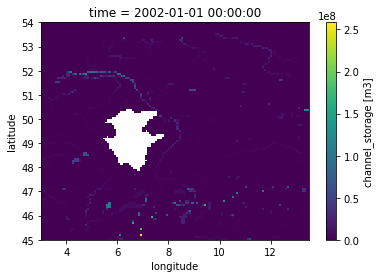

In [7]:
#check the range of the channel storage 
var_to_xarray(modelExp, variable='channel_storage').plot()

In [ ]:
#at latlon 50,10 and 47,6 change the channel storage to an absurdly high value

#first determine at which indeces in the grid these coordinates are
ind = lat_lon_boundingbox_to_variable_indices(modelExp, 'channel_storage', 50,51, 8, 9)
print(len(ind))

In [ ]:
#check the values of the channel storage at those points
#print(modelExp.get_value_at_indices('channel_storage',ind))

#change the value, and check if succesfull
modelExp.set_value_at_indices('channel_storage',ind,np.ones(len(ind)) * 3e8)

In [ ]:
modelExp.update()

In [ ]:
var_to_xarray(modelExp, variable = "channel_storage").plot()

In [ ]:
print(modelExp.get_value_at_indices('channel_storage',ind))

In [ ]:
channelStorage = modelExp.get_value('channel_storage')
print(channelStorage[ind])

In [ ]:
modelExp.set_value('channel_storage',modelExp.get_value('channel_storage') * 2)

In [ ]:
channelStorageNew = modelExp.get_value('channel_storage')
print(channelStorageNew[ind])

In [ ]:
modelExp.update()
modelRef.update()


In [ ]:
print(modelExp.get_value_at_indices('channel_storage',ind))
print(modelRef.get_value_at_indices('channel_storage',ind))

In [ ]:
modelExp.get_output_var_names()

In [ ]:
var_to_xarray(modelExp, variable = "upper_soil_storage").plot()

In [ ]:
#that doesn't work! Maybe run one timestep and see?

In [ ]:
output = []
time_units = model.get_time_units()
print(f'Running pcrglobwb', flush=True)
while model.get_current_time() < model.get_end_time():
    model.set_value_at_indices('channel_storage',ind,np.array(3e8))
    time = num2date(model.get_current_time(), time_units)
    print(f'Current time: {time}', end="\r")
    model.update()
    output.append(var_to_xarray(model, variable="discharge"))
print('')


### cleanup after the model run
After the model has run and the output of the experiment is stored, the container should be shut down properly, using the finalize command. 

### TODO: remove pickle and run entire notebook when done for publication

In [ ]:
modelExp.finalize()
modelRef.finalize()

In [ ]:
data  = xr.concat(output, dim='time')

In [ ]:
f = open('modelrunOutputWeird.pckl', 'wb')
pickle.dump(data,f)


In [ ]:
f.close()

# **Import GRDC observations**

Read the GRDC data for the period of the experiment, for the station given above. 
If you are not on jupyter.ewatercycle.org or cartesius, download the GRDC https://www.bafg.de/GRDC/EN/02_srvcs/21_tmsrs/riverdischarge_node.html and set the directory below in GRDC_DATA_HOME env var.

### TODO the four lines at the end of the cell should become part of the get_grdc_data function, which (I think) should return a dict.

In [ ]:
#on Cartesius:
#environ['GRDC_DATA_HOME']= '/projects/0/wtrcycle/GRDC/GRDC_GCOSGTN-H_27_03_2019'

#on jupyter.ewatercycle.org
environ['GRDC_DATA_HOME']= '/mnt/data/grdc/dailies' 

observations = get_grdc_data(station_id, start_date=dstart, end_date=dend)
grdc_obs = observations.to_dataframe().rename(columns = {'streamflow': 'GRDC'})
grdc_lon = observations.attrs['grdc_longitude_in_arc_degree']
grdc_lat = observations.attrs['grdc_latitude_in_arc_degree']

# Plot the results

In [ ]:
f = open('modelrunOutputTemp.pckl', 'rb')
data = pickle.load(f)
f.close()

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10), dpi=120)

data.isel(time=-1).plot(ax=axs, cmap='YlGnBu', robust=True)
axs.set_title('test')
plt.tight_layout()
fig.savefig(f'pcrglobwb_RolfTestRhine_discharge_map', bbox_inches='tight', dpi=300)

In [ ]:
pad=.2

# Write data for model output at GRDC location to pandas series,
# Use padding and max to correct for GRDC station location error
dataAtGRDCLocation = data.sel(longitude=slice(grdc_lon-pad, grdc_lon+pad), 
                         latitude=slice(grdc_lat-pad, grdc_lat+pad)
                        ).max(['longitude', 'latitude']
                        ).rename('ERA5'
                        ).to_dataframe()

dataAtGRDCLocation.index=dataAtGRDCLocation.index.to_datetimeindex()


In [ ]:
# Combine timeseries of ERA-Interim, ERA5 and GRDC observations in a pandas dataframe
df = pd.concat([dataAtGRDCLocation, grdc_obs],axis = 1)

# Note: the data come at different time stamps
print(df.head())

# For now, interpolating to get similar sets:
df = df.fillna(method='ffill').dropna()
print(df.head())

In [ ]:
fig, ax = plt.subplots(dpi=120)
df.plot(ax=ax)
ax.set_ylim(0, df.GRDC.max())
ax.set_ylabel('Streamflow (m$^3$ s$^{-1}$)')
ax.legend(['PCRGlobWB forced with ERA5','Observations from GRDC'])

dataset='ERA5'
yloc=0.6
ax.text(1.02, yloc, f"{dataset}:\n"
        f"NSE: {hm.nse(df[dataset], df['GRDC']):.2f} \n"
        f"KGE (2009): {hm.kge_2009(df[dataset], df['GRDC']):.2f}\n"
        f"SA: {hm.sa(df[dataset], df['GRDC']):.2f}\n"
        f"ME: {hm.me(df[dataset], df['GRDC']):.2f}",
        transform=ax.transAxes, va='top')

fig.savefig(f'pcrglobwb_{basin_name}_hydrograph', bbox_inches='tight', dpi=300)
